# Benfords Law Analysis
In this notebook analyze the **distribution of first significant digits** (fsd) of different aspects of an image.
These could be for example:
- The raw pixel values
- The discrete cosine transformation (DCT) values

Benfords law is an observation that in many collections of numbers, be they mathematical tables, real-life data, or combinations thereof, the leading significant digits are not uniformly distributed, as might be expected, but are heavily skewed toward the smaller digits. [[1](https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?article=1074&context=rgp_rsr)]

It is mathematically defined as (simplified) [[2](https://arxiv.org/pdf/1506.03046.pdf)]:

$$bf(d)=\beta log_b(1+\frac{1}{d})$$

with $b$ being base ($10$ for "normal" numbers) and $d$ being the possible digits (for $b=10$: $\{1,…,9\}$). The corresponding plot for $b=10$ does look as follows:

<img src="./benfords_law_ground_truth.png" alt="Benfords Law">

It was shown, that **natural** image data (e.g. produced fotographs) also follows this distribution, but GAN generated images do not. This fact was used successfully by Bonettini and collegues in [[3](https://arxiv.org/pdf/2004.07682.pdf)] to distinguish between real and fake images.

As an example dataset we will use the famous grayscale MNIST dataset, which is included in TensorFlow Keras.

In [1]:
# Import packages and settings
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import glob
import numpy.typing as npt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from math import log10, floor

pd.options.plotting.backend = "plotly"

2022-11-08 19:15:03.839155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 19:15:04.440567: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
FSD_SLOW = 0
FSD_FAST = 1
BASE_10 = 10

In [3]:
# Import and prepare data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
images = np.append(train_images, test_images, axis=0)
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')

In [35]:
def get_dct_array(image_list: npt.ArrayLike) -> npt.ArrayLike:
    """Calculates the DCT for each element in the list, flattens the result and returns a one-dimensional array.

    Args:
        image_list (npt.ArrayLike): A list of images

    Returns:
        npt.ArrayLike: A one-dimensional array of DCT values
    """
    dcts = np.array([cv2.dct(image) for image in image_list])
    dcts = dcts.flatten()
    return dcts


In [5]:
def to_fsd(values: npt.ArrayLike, mode: int = FSD_FAST) -> npt.ArrayLike:
    """Replaces each value in values with its first significant digit.

    Args:
        values (npt.ArrayLike): An array of float values

    Returns:
        npt.ArrayLike: The first significant digits of values
    """
    values = values[values != 0]
    fsd = []
    if mode == FSD_SLOW:
        for value in tqdm(values):
            num = int(abs(value * (10 ** -int(floor(log10(abs(value)))))))
            fsd.append(num)
    elif mode == FSD_FAST:
        n = np.abs(values * np.power(np.full(values.shape, 10.), -np.floor(np.log10(np.abs(values).astype("float64"))))).astype("int")
        fsd.extend(n)
    return np.array(fsd)
        

In [6]:
def count_fsds(fsds: npt.ArrayLike, base: int = BASE_10) -> npt.ArrayLike:
    """Counts up the occurence of each digit, depending on the base (1-9 for base 10).

    Args:
        fsds (npt.ArrayLike): An array of digits

    Returns:
        npt.ArrayLike: An array of the summed digits of length base - 1
    """
    count = []
    for i in range(1,base):
        count.append(np.count_nonzero(fsds == i))
    return np.array(count)

In [7]:
def benfords_law() -> npt.ArrayLike:
    """Create the ground truth distribution according to benfords law for base10 digits.

    Returns:
        npt.ArrayLike: The benfords law distribution for base10 digits
    """
    bf_law = []
    for i in range(1,10):
        bf_law.append(log10(1 + (1 / i)))
    return np.array(bf_law)

In [8]:
def plot_df_comparison(fsd_count_dist: npt.ArrayLike, base: int = BASE_10, title: str = "Measurements vs. Benfords Law"):
    """Plot Benfords law against measured first significant digits.

    Args:
        fsd_count_dist (npt.ArrayLike): Measured first significant digits
        base (int, optional): Number base. Defaults to BASE_10.
        title (str, optional): Title of the produced plot. Defaults to "Measurements vs. Benfords Law".
    """
    df = pd.DataFrame()
    df["digit"] = [i for i in range(1, base, 1)]
    df["MNIST FSD count"] = fsd_count_dist
    df["Benfords Law (ground truth)"] = benfords_law()

    fig = go.Figure()
    fig.add_bar(x=df["digit"], y=df["MNIST FSD count"], name="Measurements")
    fig.add_scatter(x=df["digit"], y=df["Benfords Law (ground truth)"], name="Ground Truth")
    fig.update_layout(title=title, xaxis_title="Digits", yaxis_title="Distribution")

    fig.show()

In [9]:
# Run dct on images and gather first significant digits (Slow version - pure python)
dcts = get_dct_array(images)
fsd = to_fsd(dcts, mode=FSD_SLOW)

# Count fsds
fsd_count = count_fsds(fsd, base=BASE_10)

# Calculate distribution of each digit
fsd_count_dist = fsd_count / np.sum(fsd_count)

# Plot distribution against the ground truth benfords law
plot_df_comparison(fsd_count_dist=fsd_count_dist, title="DCT FSDs vs. Benfords Law")

100%|██████████| 54879999/54879999 [01:46<00:00, 514650.90it/s]


In [39]:
# Run dct on images and gather first significant digits (Fast version - numpy)
dcts = get_dct_array(images)
fsd = to_fsd(dcts, mode=FSD_FAST)

# Count fsds
fsd_count = count_fsds(fsd, base=BASE_10)

# Calculate distribution of each digit
fsd_count_dist = fsd_count / np.sum(fsd_count)

# Plot distribution against the ground truth benfords law
plot_df_comparison(fsd_count_dist, title="DCT FSDs vs. Benfords Law")

In [11]:
# Gather first significant digits on raw images
i = images.flatten()
fsd = to_fsd(i)

# Count fsds
fsd_count = count_fsds(fsd, base=BASE_10)

# Calculate distribution of each digit
fsd_count_dist = fsd_count / np.sum(fsd_count)

# Plot distribution against the ground truth benfords law
plot_df_comparison(fsd_count_dist, title="Raw Images FSDs vs. Benfords Law")

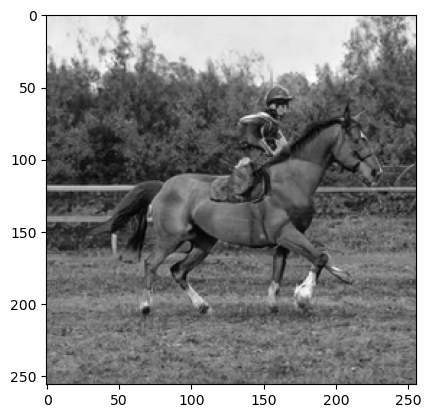

In [12]:
horses = np.array([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob("horses/000000/*.png")]).astype("float32")

plt.imshow(horses[0], cmap=plt.cm.gray)
plt.show()

In [13]:
dcts = get_dct_array(horses)
fsd = to_fsd(dcts)
fsd_count = count_fsds(fsd)
fsd_count_dist = fsd_count / np.sum(fsd_count)

plot_df_comparison(fsd_count_dist=fsd_count_dist, title="GAN DCT FSDs vs. Benfords Law")

In [14]:
h = horses.flatten()
fsd = to_fsd(h)
fsd_count = count_fsds(fsd)
fsd_count_dist = fsd_count / np.sum(fsd_count)

plot_df_comparison(fsd_count_dist=fsd_count_dist, title="Raw GAN FSDs vs. Benfords Law")